In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

module_path = (Path().resolve().parent/ "Modules")
sys.path.append(str(module_path))

import my_modules, model_tuner, features

pd.set_option("display.max_columns", None)

In [2]:
df = pd.read_csv("../Data/train_data_tmp.csv", encoding="shift-jis")
odds_df = pd.read_csv("../Data/Time_Series_Odds_win_odds.csv", encoding="shift-jis")

In [3]:
df2 = my_modules.preprocessing(df)

In [4]:
df3 = my_modules.common_process(df2)

C:\Users\ken05\Documents\others\HORSE_RACING\Modules\my_modules.py:76: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["place_num"] = df["place"].replace(place_dict).astype(int)


In [5]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252411 entries, 252634 to 0
Data columns (total 74 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   PCI                  251103 non-null  float64       
 1   PCI3                 252411 non-null  float64       
 2   RPCI                 252411 non-null  float64       
 3   race_id              252411 non-null  int64         
 4   year                 252411 non-null  int64         
 5   month                252411 non-null  int64         
 6   day                  252411 non-null  int64         
 7   times                252411 non-null  int64         
 8   place                252411 non-null  object        
 9   daily                252411 non-null  object        
 10  race_num             252411 non-null  int64         
 11  horse                252411 non-null  object        
 12  jockey_id            252411 non-null  object        
 13  trainer_id         

In [6]:
def feature_engineering(df_to_copy, feature_col_to_copy=None):
    if feature_col_to_copy == None :
        feature_col_to_copy = ["waku_num", "horse_num", "sex", "age", "basis_weight", "blinker", "weight", "inc_dec"]
    feature_col = feature_col_to_copy.copy()
    df = df_to_copy.copy()

    # 直近3レースの結果とその平均, 過去全てのレースの記録の平均を追加
    last_race_col = ["weight", "inc_dec", "last_3F_time", "Ave_3F", "PCI", "RPCI"]
    for col in last_race_col:
        grouped = df.groupby("horse", observed=True)[col]
        for i in range(1, 4):
            # 過去1-3レースの結果を追加
            colname = f"{col}_last_{i}"
            df[colname] = grouped.shift(1)
            feature_col.append(colname)
        
        # 過去3レース分の結果の平均を追加
        df[f"{col}_mean_last_1_to_3"] = df[[f"{col}_last_{i}" for i in range(1, 4)]].mean(axis=1, skipna=True)
        feature_col.append(f"{col}_mean_last_1_to_3")

        # 過去全レース文の特徴量を追加
        cumsum = grouped.cumsum()
        count = grouped.cumcount()
        df[f"{col}_mean_all"] = (cumsum - df[col]) / count.replace(0, np.nan)
        feature_col.append(f"{col}_mean_all")


    # 特徴量を入れておくための辞書(fragment防止)
    dict_for_df = dict()

    # 過去その馬の全てのレースの1着率
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df,cols=["horse"])

    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["dist"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["track_code"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["field_type"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["turn_type"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["weather"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["state"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["place"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["corner_num"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["class_code"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["basis_weight"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["age_code"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["weight_code"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["jockey_id"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["jockey_id", "class_code"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["jockey_id", "place"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["jockey_id", "dist"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["jockey_id", "field_type"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["jockey_id", "place", "dist"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["jockey_id", "place", "field_type", "dist"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["weather", "state"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["dist", "corner_num"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["dist", "track_code"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["dist", "class_code"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["place", "field_type", "dist"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["place", "field_type", "dist", "class_code"])

    # 過去他の馬も含む全レースで同条件でのレースの1着の確率
    # dist, field_type, place, race_type, corner_num系
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["dist", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["dist", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["dist", "horse_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["field_type", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["field_type", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["field_type", "horse_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["place", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["place", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["place", "horse_num"])

    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["field_type", "dist", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["field_type", "dist", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["field_type", "dist", "horse_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["dist", "place", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["dist", "place", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["dist", "place", "horse_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["field_type", "place", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["field_type", "place", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["field_type", "place", "horse_num"])

    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["race_type", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["race_type", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["race_type", "horse_num"])
    
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["corner_num", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["corner_num", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["corner_num", "horse_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["corner_num", "dist", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["corner_num", "dist", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["corner_num", "dist", "horse_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["corner_num", "place", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["corner_num", "place", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["corner_num", "place", "horse_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["corner_num", "field_type", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["corner_num", "field_type", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["corner_num", "field_type", "horse_num"])



    # leg系(リーク情報なので一旦停止)
    '''
    dict_for_df, feature_col = grouped_leg_winning_rate(df, feature_col, dict_for_df, cols=["leg"])
    dict_for_df, feature_col = grouped_leg_winning_rate(df, feature_col, dict_for_df, cols=["leg", "dist"])
    dict_for_df, feature_col = grouped_leg_winning_rate(df, feature_col, dict_for_df, cols=["leg", "place"])
    dict_for_df, feature_col = grouped_leg_winning_rate(df, feature_col, dict_for_df, cols=["leg", "field_type"])
    dict_for_df, feature_col = grouped_leg_winning_rate(df, feature_col, dict_for_df, cols=["leg", "place", "field_type"])
    dict_for_df, feature_col = grouped_leg_winning_rate(df, feature_col, dict_for_df, cols=["leg", "place", "dist"])
    dict_for_df, feature_col = grouped_leg_winning_rate(df, feature_col, dict_for_df, cols=["leg", "dist", "field_type"])
    dict_for_df, feature_col = grouped_leg_winning_rate(df, feature_col, dict_for_df, cols=["leg", "race_type"])
    dict_for_df, feature_col = grouped_leg_winning_rate(df, feature_col, dict_for_df, cols=["leg", "race_type", "waku"])
    dict_for_df, feature_col = grouped_leg_winning_rate(df, feature_col, dict_for_df, cols=["leg", "race_type", "waku_num"])
    dict_for_df, feature_col = grouped_leg_winning_rate(df, feature_col, dict_for_df, cols=["leg", "race_type", "horse_num"])
    '''

    # jockey_id系
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "place"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "place", "dist"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "field_type"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "field_type", "dist"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "field_type", "place"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "dist"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "race_type"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "race_type", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "race_type", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "race_type", "horse_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "class_code"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "class_code", "place"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "class_code", "dist"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "class_code", "field_type"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "class_code", "race_type"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "class_code", "race_type", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "class_code", "race_type", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "class_code", "race_type", "horse_num"])

    # jockey_id-turn_type系
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "turn_type"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "turn_type", "dist"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "turn_type", "place"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "turn_type", "field_type"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "turn_type", "dist", "place"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "turn_type", "dist", "field_type"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "turn_type", "place", "field_type"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "turn_type", "dist", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "turn_type", "dist", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "turn_type", "dist", "horse_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "turn_type", "place", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "turn_type", "place", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "turn_type", "place", "horse_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "turn_type", "field_type", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "turn_type", "field_type", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "turn_type", "field_type", "horse_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "turn_type", "dist", "place", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "turn_type", "dist", "place", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "turn_type", "dist", "place", "horse_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "turn_type", "dist", "field_type", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "turn_type", "dist", "field_type", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "turn_type", "dist", "field_type", "horse_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "turn_type", "place", "field_type", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "turn_type", "place", "field_type", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["jockey_id", "turn_type", "place", "field_type", "horse_num"])


    # trainer_id系
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "place"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "place", "dist"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "field_type"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "field_type", "dist"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "field_type", "place"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "dist"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "race_type"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "race_type", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "race_type", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "race_type", "horse_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "class_code"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "class_code", "place"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "class_code", "dist"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "class_code", "field_type"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "class_code", "race_type"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "class_code", "race_type", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "class_code", "race_type", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "class_code", "race_type", "horse_num"])

    # trainer_id-turn_type系
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "turn_type"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "turn_type", "dist"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "turn_type", "place"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "turn_type", "field_type"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "turn_type", "dist", "place"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "turn_type", "dist", "field_type"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "turn_type", "place", "field_type"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "turn_type", "dist", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "turn_type", "dist", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "turn_type", "dist", "horse_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "turn_type", "place", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "turn_type", "place", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "turn_type", "place", "horse_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "turn_type", "field_type", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "turn_type", "field_type", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "turn_type", "field_type", "horse_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "turn_type", "dist", "place", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "turn_type", "dist", "place", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "turn_type", "dist", "place", "horse_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "turn_type", "dist", "field_type", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "turn_type", "dist", "field_type", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "turn_type", "dist", "field_type", "horse_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "turn_type", "place", "field_type", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "turn_type", "place", "field_type", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["trainer_id", "turn_type", "place", "field_type", "horse_num"])


    #jokey_id & trainer_id系


    # mother系
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["mother"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["mother", "place"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["mother", "dist"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["mother", "field_type"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["mother", "turn_type"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["mother", "race_type"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["mother", "track_code"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["mother", "class_code"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["mother", "corner_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["mother", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["mother", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["mother", "horse_num"])

    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["mother", "place", "dist"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["mother", "place", "field_type"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["mother", "dist", "field_type"])

    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["mother", "place", "dist", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["mother", "place", "dist", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["mother", "place", "dist", "horse_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["mother", "dist", "field_type", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["mother", "dist", "field_type", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["mother", "dist", "field_type", "horse_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["mother", "field_type", "place", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["mother", "field_type", "place", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["mother", "field_type", "place", "horse_num"])

    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["mother", "race_type", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["mother", "race_type", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["mother", "race_type", "horse_num"])
        

    # father系
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["father"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["father", "place"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["father", "dist"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["father", "field_type"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["father", "turn_type"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["father", "race_type"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["father", "track_code"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["father", "class_code"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["father", "corner_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["father", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["father", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["father", "horse_num"])

    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["father", "place", "dist"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["father", "place", "field_type"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["father", "dist", "field_type"])

    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["father", "place", "dist", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["father", "place", "dist", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["father", "place", "dist", "horse_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["father", "dist", "field_type", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["father", "dist", "field_type", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["father", "dist", "field_type", "horse_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["father", "field_type", "place", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["father", "field_type", "place", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["father", "field_type", "place", "horse_num"])

    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["father", "race_type", "waku"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["father", "race_type", "waku_num"])
    dict_for_df, feature_col = grouped_winning_rate(df, feature_col, dict_for_df, cols=["father", "race_type", "horse_num"])
    
    # broodmare_sire系

    # broodmare_sire_type系

    # horse_color系



    # 最後にまとめてdict_for_dfをdfにくっつける
    processed_df = pd.DataFrame(dict_for_df)
    df = pd.concat([df, processed_df], axis=1)


    # その他特徴量を追加
    # weightに関する特徴量
    # weightは300kg以下の馬がいないことからこのようにした。
    df["basis_weight_per_weight"] = df["basis_weight"] / df["weight"].clip(lower=300) * 100 # 斤量/馬体重（％）
    feature_col.append("basis_weight_per_weight")
    df["basis_weight_plus_weight"] = df["basis_weight"] + df["weight"] # 斤量＋馬体重
    feature_col.append("basis_weight_plus_weight")
    df["inc_dec_rate"] = df["inc_dec"] / df["weight"].clip(lower=300) * 100 # 増減/馬体重（％）
    feature_col.append("inc_dec_rate")

    # 生涯獲得賞金
    df["lifetime_prize"] = df.groupby("horse", observed=True)["prize"].cumsum() - df["prize"]
    feature_col.append("lifetime_prize")

    # 生涯獲得賞金 / 今まで出走したレース
    df["lifetime_prize_per_race"] = df["lifetime_prize"] / df.groupby("horse", observed=True)["prize"].cumcount().replace(np.nan, 0)
    feature_col.append("lifetime_prize_per_race")
    
    # 前回と同じfield_typeかどうか
    df["last_field_type"] = df.groupby(["horse"], observed=True)["field_type"].shift(1)
    feature_name = "is_same_field_type_as_last"
    df[feature_name] =  df["field_type"] == df["last_field_type"]
    df[feature_name] = df[feature_name].astype("category")
    df = df.drop(["last_field_type"], axis=1)
    feature_col.append(feature_name)

    # 前回と同じクラスか
    df["last_class_code"] = df.groupby(["horse"], observed=True)["class_code"].shift(1)
    feature_name = "is_same_class_code_as_last"
    df[feature_name] = df["class_code"] == df["last_class_code"]
    df[feature_name] = df[feature_name].astype("category")
    df = df.drop(["last_class_code"], axis=1)
    feature_col.append(feature_name)

    # 前回と同じジョッキーか
    df["last_jockey"] = df.groupby(["horse"], observed=True)["jockey_id"].shift(1)
    feature_name = "is_same_jockey_as_last"
    df[feature_name] = df["jockey_id"] == df["last_jockey"]
    df[feature_name] = df[feature_name].astype("category")
    df = df.drop(["last_jockey"], axis=1)
    feature_col.append(feature_name)

    # 中何日か
    df["last_race_date"] = df.groupby("horse", observed=True)["datetime"].shift(1)
    df["interval"] = df["datetime"] - df["last_race_date"]
    df["interval_day"] = df["interval"].dt.days
    df["interval_week"] = df["interval_day"] // 7
    df = df.drop(["last_race_date", "interval"], axis=1)
    feature_col.append("interval_day")
    feature_col.append("interval_week")

    # 今回が一番位の高いレースか
    df["class_code"] = df["class_code"].astype(int) # categoryなので、一度intに変換（cummaxが使えないため）
    df["is_highest_class"] = df.groupby("horse", observed=True)["class_code"].cummax() == df["class_code"]
    feature_col.append("is_highest_class")
    df["class_code"] = df["class_code"].astype("category") # categoryに戻す

    # 最後に全体を正規化（std=1とする)
    num_col = df[feature_col].select_dtypes(include=["number"]).columns.tolist()
    grouped_mean = df.groupby("id_for_fold", observed=True)[num_col].transform("mean")
    grouped_std = df.groupby("id_for_fold", observed=True)[num_col].transform("std")
    df[num_col] = (df[num_col] - grouped_mean) / grouped_std

    # 後でランキング化とかも付ける予定

    # dfを表示
    print(feature_col)
    display(df.tail())

    return df, feature_col


# 馬でグループ化したtarget-encodingをする関数
def grouped_horse_winning_rate(df_to_copy, feature_col_to_copy, cols=None):
    df = df_to_copy.copy()
    feature_col = feature_col_to_copy.copy()

    if cols == None :
        print("Error: please select cols")
        return
    
    # 1着の確率で計算
    grouped = df.groupby(["horse", *cols], observed=True)["target"]
    cumsum = grouped.cumsum()
    count = grouped.cumcount()
    feature_name = "horse_win_rate_" + "_".join(cols)
    df[feature_name] = (cumsum-df["target"]) / count.replace(0, np.nan)

    feature_col.append(feature_name)

    # 1-3着の確率で計算
    grouped = df.groupby(["horse", *cols], observed=True)["target3"]
    cumsum = grouped.cumsum()
    count = grouped.cumcount()
    feature_name = "horse_win_rate3_" + "_".join(cols)
    df[feature_name] = (cumsum-df["target3"]) / count.replace(0, np.nan)

    feature_col.append(feature_name)

    return df, feature_col


# 過去全てのレースでグループ化したtarget-encodingをする関数
def grouped_winning_rate(df_to_copy, feature_col_to_copy, dict_for_df, cols):
    df = df_to_copy.copy()
    feature_col = feature_col_to_copy.copy()
    grouped1 = df.groupby(cols, observed=True)
    grouped2 = df.groupby(["id_for_fold", *cols], observed=True)

    # 同じ条件で1着になるの確率を計算
    bunsi1 = grouped1["target"].cumsum() - grouped2["target"].cumsum()
    bunbo1 = grouped1["target"].cumcount() - grouped2["target"].cumcount()

    feature_name = "all_win_rate_" + "_".join(cols)
    feature_col.append(feature_name)
    dict_for_df[feature_name] = bunsi1 / bunbo1.replace(0, np.nan)

    # 同じ条件で1-3着になるの確率を計算
    bunsi3 = grouped1["target3"].cumsum() - grouped2["target3"].cumsum()
    bunbo3 = grouped1["target3"].cumcount() - grouped2["target3"].cumcount()

    feature_name3 = "all_win_rate3_" + "_".join(cols)
    feature_col.append(feature_name3)
    dict_for_df[feature_name3] = bunsi3 / bunbo3.replace(0, np.nan)


    return dict_for_df, feature_col

In [7]:
feature_col = ["waku_num", "horse_num", "sex", "age", "basis_weight", "blinker", "weight", "inc_dec"]
df4, feature_col2 = features.feature_engineering(df3, feature_col)

calculating trueskill of horse is processing
calculating trueskill of jockey is processing
['waku_num', 'horse_num', 'sex', 'age', 'basis_weight', 'blinker', 'weight', 'inc_dec', 'weight_last_1', 'weight_last_2', 'weight_last_3', 'weight_mean_last_1_to_3', 'weight_mean_all', 'inc_dec_last_1', 'inc_dec_last_2', 'inc_dec_last_3', 'inc_dec_mean_last_1_to_3', 'inc_dec_mean_all', 'last_3F_time_last_1', 'last_3F_time_last_2', 'last_3F_time_last_3', 'last_3F_time_mean_last_1_to_3', 'last_3F_time_mean_all', 'Ave_3F_last_1', 'Ave_3F_last_2', 'Ave_3F_last_3', 'Ave_3F_mean_last_1_to_3', 'Ave_3F_mean_all', 'PCI_last_1', 'PCI_last_2', 'PCI_last_3', 'PCI_mean_last_1_to_3', 'PCI_mean_all', 'RPCI_last_1', 'RPCI_last_2', 'RPCI_last_3', 'RPCI_mean_last_1_to_3', 'RPCI_mean_all', 'all_win_rate_horse', 'all_win_rate3_horse', 'horse_win_rate_dist', 'horse_win_rate3_dist', 'horse_win_rate_track_code', 'horse_win_rate3_track_code', 'horse_win_rate_field_type', 'horse_win_rate3_field_type', 'horse_win_rate_tur

,PCI,PCI3,RPCI,race_id,year,month,day,times,place,daily,race_num,horse,jockey_id,trainer_id,horse_N,waku_num,horse_num,class_code,track_code,corner_num,dist,state,weather,age_code,sex,age,basis_weight,blinker,weight,inc_dec,weight_code,win_odds,win_odds_1,win_odds_1_pop,win_odds_2,win_odds_2_pop,win_mul_odds_Hi,win_mul_odds_Lo,win_mul_odds_1_Hi,win_mul_odds_1_Lo,win_mul_odds_1_pop,win_mul_odds_2_Hi,win_mul_odds_2_Lo,win_mul_odds_2_pop,rank,time_diff,time,corner1_rank,corner2_rank,corner3_rank,corner4_rank,last_3F_time,last_3F_rank,Ave_3F,last_3F_time_diff,leg,pop,prize,error_code,father,mother,broodmare_sire,broodmare_sire_type,horse_color,id,id_for_fold,field_type,flat_or_jump,turn_type,race_type,waku,datetime,target,target3,weight_last_1,weight_last_2,weight_last_3,weight_mean_last_1_to_3,weight_mean_all,inc_dec_last_1,inc_dec_last_2,inc_dec_last_3,inc_dec_mean_last_1_to_3,inc_dec_mean_all,last_3F_time_last_1,last_3F_time_last_2,last_3F_time_last_3,last_3F_time_mean_last_1_to_3,last_3F_time_mean_all,Ave_3F_last_1,Ave_3F_last_2,Ave_3F_last_3,Ave_3F_mean_last_1_to_3,Ave_3F_mean_all,PCI_last_1,PCI_last_2,PCI_last_3,PCI_mean_last_1_to_3,PCI_mean_all,RPCI_last_1,RPCI_last_2,RPCI_last_3,RPCI_mean_last_1_to_3,RPCI_mean_all,horse_win_rate_dist,horse_win_rate3_dist,horse_win_rate_track_code,horse_win_rate3_track_code,horse_win_rate_field_type,horse_win_rate3_field_type,horse_win_rate_turn_type,horse_win_rate3_turn_type,horse_win_rate_weather,horse_win_rate3_weather,horse_win_rate_state,horse_win_rate3_state,horse_win_rate_place,horse_win_rate3_place,horse_win_rate_corner_num,horse_win_rate3_corner_num,horse_win_rate_class_code,horse_win_rate3_class_code,horse_win_rate_basis_weight,horse_win_rate3_basis_weight,horse_win_rate_age_code,horse_win_rate3_age_code,horse_win_rate_weight_code,horse_win_rate3_weight_code,horse_win_rate_jockey_id,horse_win_rate3_jockey_id,horse_win_rate_jockey_id_class_code,horse_win_rate3_jockey_id_class_code,horse_win_rate_jockey_id_place,horse_win_rate3_jockey_id_place,horse_win_rate_jockey_id_dist,horse_win_rate3_jockey_id_dist,horse_win_rate_jockey_id_field_type,horse_win_rate3_jockey_id_field_type,horse_win_rate_jockey_id_place_dist,horse_win_rate3_jockey_id_place_dist,horse_win_rate_jockey_id_place_field_type_dist,horse_win_rate3_jockey_id_place_field_type_dist,horse_win_rate_weather_state,horse_win_rate3_weather_state,horse_win_rate_dist_corner_num,horse_win_rate3_dist_corner_num,horse_win_rate_dist_track_code,horse_win_rate3_dist_track_code,horse_win_rate_dist_class_code,horse_win_rate3_dist_class_code,horse_win_rate_place_field_type_dist,horse_win_rate3_place_field_type_dist,horse_win_rate_place_field_type_dist_class_code,horse_win_rate3_place_field_type_dist_class_code,all_win_rate_horse,all_win_rate3_horse,all_win_rate_dist_waku,all_win_rate3_dist_waku,all_win_rate_dist_waku_num,all_win_rate3_dist_waku_num,all_win_rate_dist_horse_num,all_win_rate3_dist_horse_num,all_win_rate_field_type_waku,all_win_rate3_field_type_waku,all_win_rate_field_type_waku_num,all_win_rate3_field_type_waku_num,all_win_rate_field_type_horse_num,all_win_rate3_field_type_horse_num,all_win_rate_place_waku,all_win_rate3_place_waku,all_win_rate_place_waku_num,all_win_rate3_place_waku_num,all_win_rate_place_horse_num,all_win_rate3_place_horse_num,all_win_rate_field_type_dist_waku,all_win_rate3_field_type_dist_waku,all_win_rate_field_type_dist_waku_num,all_win_rate3_field_type_dist_waku_num,all_win_rate_field_type_dist_horse_num,all_win_rate3_field_type_dist_horse_num,all_win_rate_dist_place_waku,all_win_rate3_dist_place_waku,all_win_rate_dist_place_waku_num,all_win_rate3_dist_place_waku_num,all_win_rate_dist_place_horse_num,all_win_rate3_dist_place_horse_num,all_win_rate_field_type_place_waku,all_win_rate3_field_type_place_waku,all_win_rate_field_type_place_waku_num,all_win_rate3_field_type_place_waku_num,all_win_rate_field_type_place_horse_num,all_win_rate3_field_type_place_horse_num,all_win_rate_race_type_waku,all_win_rate3_race

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# 特徴量選択
def feature_selection(df, feature_col, max_features=200):
    X, y = df[feature_col], df["target"]

    model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
    selector = SelectFromModel(estimator=model)
    selector.fit(X, y)

[I 2025-06-22 19:31:12,024] A new study created in memory with name: no-name-5704ac63-8d93-4f11-9a92-8dc9824f9939
[I 2025-06-22 19:31:24,939] Trial 0 finished with value: 0.23333561383426013 and parameters: {'max_bin': 102, 'num_leaves': 96, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 5.9865848459837805, 'bagging_fraction': 0.3248149123539492, 'bagging_freq': 16, 'feature_fraction': 0.15227525095137953, 'lambda_l1': 0.6245760287469893, 'lambda_l2': 0.002570603566117598, 'min_gain_to_split': 7.080725777960454, 'max_depth': 4, 'learning_rate': 0.7579479953348001, 'path_smooth': 8.324426408004218}. Best is trial 0 with value: 0.23333561383426013.
[I 2025-06-22 19:32:06,590] Trial 1 finished with value: 0.22284690032546672 and parameters: {'max_bin': 62, 'num_leaves': 20, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 3.0424224365529544, 'bagging_fraction': 0.6198051453057902, 'bagging_freq': 44, 'feature_fraction': 0.36210622617823773, 'lambda_l1': 0.0032112643094417484, 'lambd

Best params :  {'max_bin': 135, 'num_leaves': 20, 'min_data_in_leaf': 45, 'min_sum_hessian_in_leaf': 4.414514871925122, 'bagging_fraction': 0.9329417598596752, 'bagging_freq': 77, 'feature_fraction': 0.19238153953280962, 'lambda_l1': 5.6639862050515255, 'lambda_l2': 0.004504939656097472, 'min_gain_to_split': 2.7145208343478764, 'max_depth': 55, 'learning_rate': 0.013863044026097364, 'path_smooth': 3.0216811417190215}


Sum of predict      is : 15
Sum of predict rate is : 0.0001973918


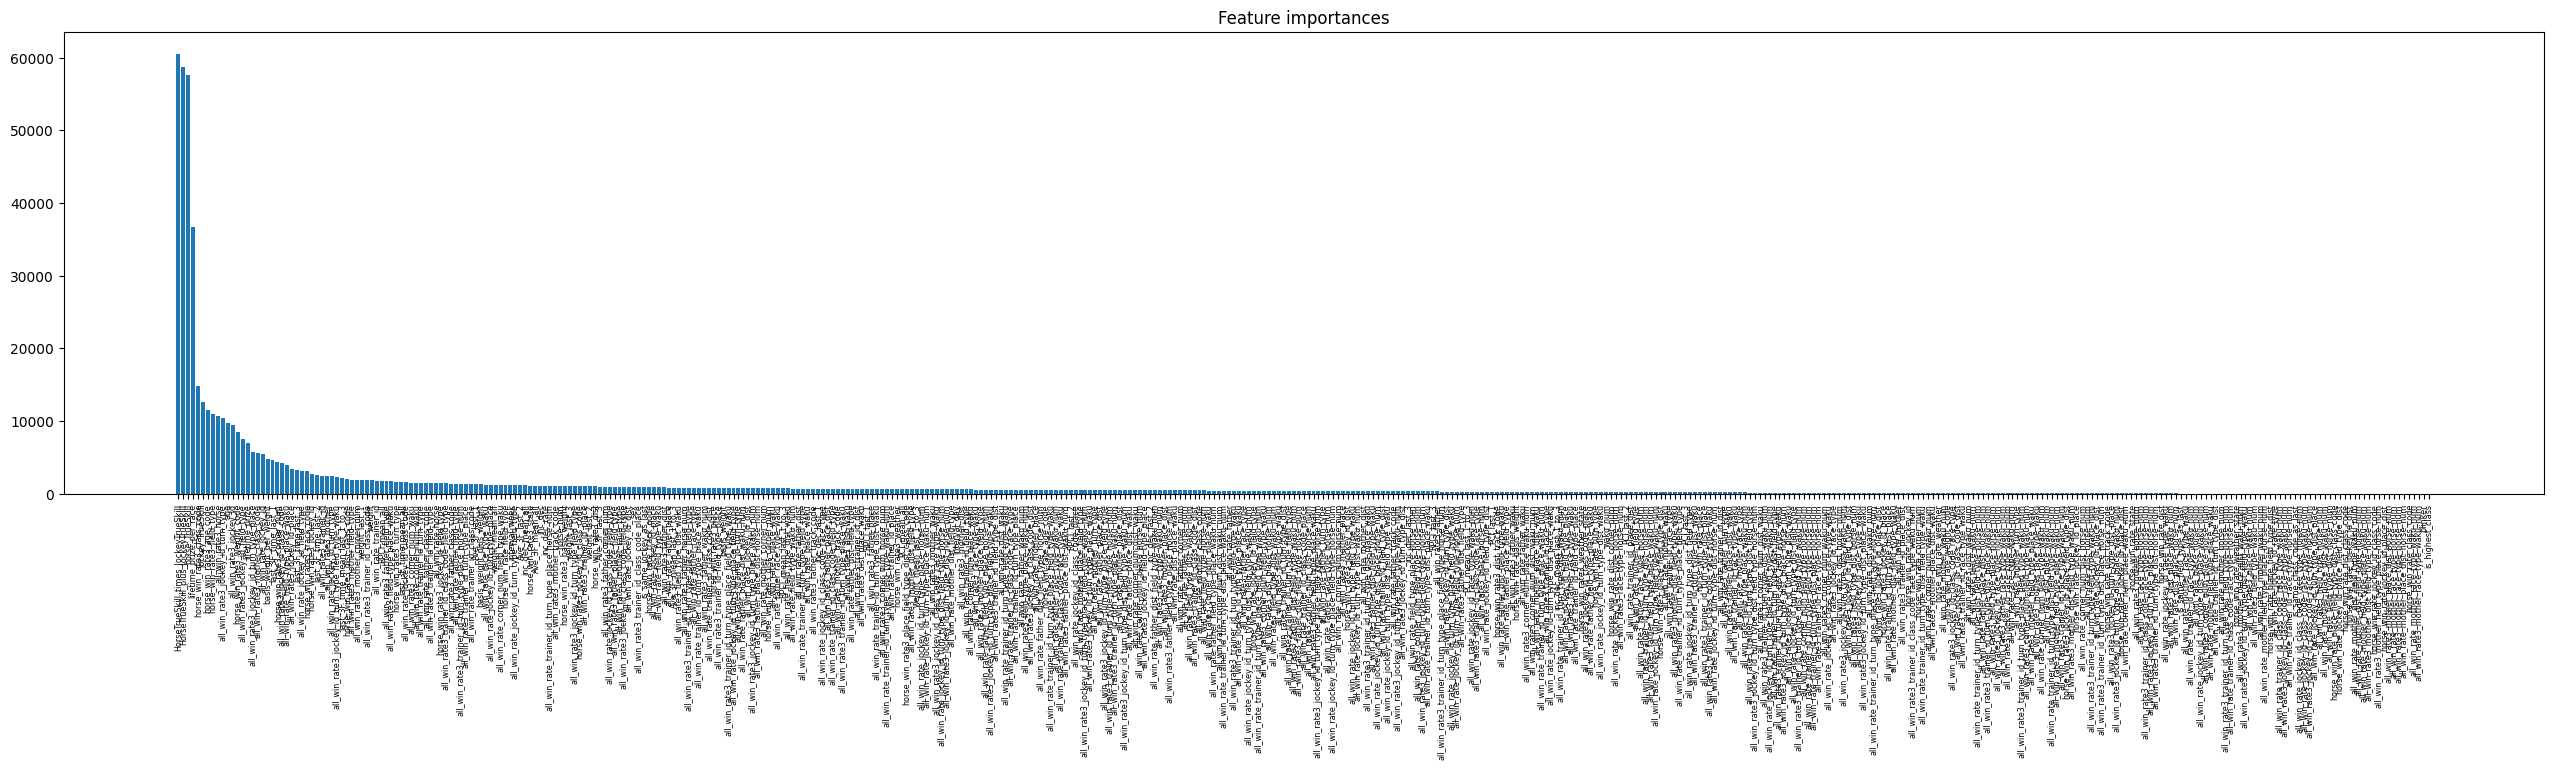

,date,memo,horse_5,horse_6,horse7,horse_8,horse_9,horse_10,horse_11,horse_12,horse_13,horse_14,horse_15,horse_16,horse_17,horse_18,sum_of_logloss,roc_auc_score
0,2025/06/22 20:05,"add TrueSkill(horse and jockey), in JV dataset...",0.371430,0.368079,0.333292,0.317952,0.297559,0.269717,0.254413,0.237617,0.227904,0.221205,0.211270,0.199142,0.179881,0.183562,3.673022,0.794921
1,2025/06/22 19:07,"add TrueSkill(horse and jockey), in JV dataset...",0.373807,0.370686,0.333505,0.316754,0.297187,0.269865,0.254883,0.237526,0.227690,0.221059,0.211130,0.199338,0.181075,0.183461,3.677967,0.794926
2,2025/06/12 22:51,"add lifetimeprize/race and trainer_id, in JV d...",0.262895,0.351931,0.328656,0.370208,0.301947,0.291383,0.261806,0.237445,0.238678,0.236072,0.217780,0.201274,0.179347,0.192842,3.672263,0.772801
3,2025/06/12 20:53,"add last race results, bloods infomation with ...",0.208531,0.312799,0.357150,0.357760,0.300641,0.297344,0.266711,0.233023,0.241540,0.235284,0.218897,0.201750,0.179552,0.191190,3.602171,0.770300
4,2025/06/06 15:29,No feature engineering with yeo-johnson-transf...,0.461397,0.470164,0.397626,0.369435,0.344003,0.312507,0.297227,0.279669,0.266719,0.250942,0.239750,0.229268,0.213745,0.211244,4.343695,0.621086
5,2025/06/06 15:16,No feature engineering. n_rials=100.,0.461984,0.489677,0.392669,0.372894,0.345458,0.312119,0.298260,0.278618,0.268310,0.252885,0.242601,0.230501,0.214274,0.213532,4.373781,0.613889


C:\Users\ken05\Documents\others\HORSE_RACING\Modules\model_tuner.py:124: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\ken05\Documents\others\HORSE_RACING\Modules\model_tuner.py:124: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ken05\Documents\others\HORSE_RACING\Modules\model_tuner.py:125: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) ins

In [8]:
memo = "add TrueSkill(horse and jockey), in JV dataset. n_rials=50."
model, df_pred = model_tuner.simple_lightGBM(df4, feature_col2, memo=memo, n_trials=50, save_result=True, visualization=True)

In [15]:
tmp =  df_pred[df_pred["class_pred"] == 1][["id_for_fold", "horse", "pred"]].sort_values("pred", ascending=False)
tmp.head(10)

,id_for_fold,horse,pred
17278,2025020805010303,アドマイヤデイトナ,0.568962
46663,2024060905030406,レッドアトレーヴ,0.567925
45153,2024062205030710,アッシュルバニパル,0.561691
32503,2024100605040201,ドゥカート,0.558640
49478,2024051805020906,アッシュルバニパル,0.553075
40277,2024072801010409,アドマイヤテラ,0.546749
1052,2025060805030209,ウィクトルウェルス,0.539357
32849,2024100505040110,アッシュルバニパル,0.534345
34951,2024091507030402,オトメナシャチョウ,0.522059
36021,2024090104030808,キャネル,0.517971


In [11]:
df_pred[df_pred["class_pred"] == 1][["id_for_fold", "horse", "pred"]].tail(10)

,id_for_fold,horse,pred
1118,2025053105021103,ダンケルド,0.535257
1296,2025053108021103,カンピドリオ,0.503333
810,2025060105021203,セブンメデュラス,0.680149
467,2025060705030104,エポナ,0.501113
572,2025060709030107,ヴァリディシームス,0.502276
349,2025060705030112,ロッシニアーナ,0.518586
122,2025060805030204,マックスキュー,0.565558
48,2025060805030209,ウィクトルウェルス,0.704738
14,2025060805030211,ジャンタルマンタル,0.531910
1,2025060805030212,サノノワンダー,0.503865


正規化前の勝率が一番高いメモリアカフェのレース↓

In [12]:
tmp = df_pred[df_pred["id_for_fold"] == 2025032306020803][["horse", "horse_num", "win_odds", "pred"]]
tmp["pred"] = tmp["pred"] / tmp["pred"].sum()
display(tmp.sort_values("pred", ascending=False))

,horse,horse_num,win_odds,pred
9894,メモリアカフェ,1.553797,1.6,0.470571
9898,デアマトローナ,0.836660,15.5,0.154882
9896,オンクラウドナイン,-1.314751,4.8,0.067935
9899,ノイシュタット,-0.836660,5.8,0.056291
9900,リアライズハロック,0.119523,14.6,0.047890
9897,カズナリ,-1.075706,69.8,0.031610
9895,ゲンパチルーナ,0.597614,15.7,0.029986
9901,ハルノート,1.314751,83.4,0.027959
9905,ロジジェンス,-0.358569,260.7,0.026641
9903,トラストギャロップ,1.075706,181.3,0.023864


#### 安田記念↓

In [13]:
tmp = df_pred[df_pred["id_for_fold"] == 2025060805030211][["horse", "horse_num", "win_odds", "pred"]]
tmp["pred"] = tmp["pred"] / tmp["pred"].sum()
display(tmp.sort_values("pred", ascending=False))

,horse,horse_num,win_odds,pred
14,ジャンタルマンタル,0.093659,4.3,0.318524
25,シックスペンス,-1.592196,4.4,0.151006
20,エコロヴァルツ,-0.280976,18.8,0.108082
16,ソウルラッシュ,0.655610,3.3,0.064830
17,ブレイディヴェーグ,1.592196,9.4,0.054903
30,トロヴァトーレ,1.217562,29.6,0.051102
23,マッドクール,-1.217562,35.4,0.045668
24,ジュンブロッサム,1.404879,13.7,0.034741
18,ウインマーベル,-1.030244,38.3,0.032675
22,ウォーターリヒト,0.842927,13.0,0.032197


In [14]:
# 各レースで、一番確率が高い単勝のみ購入した場合の勝ち額
def calc_max_pred_strategy(pred_df):
    pred_df["max_pred"] = pred_df.groupby("id_for_fold", observed=True)["pred"].transform("max")
    pred_df["max_pred_flg"] = pred_df["max_pred"] == pred_df["pred"]
    pred_df["bought_ticket_flg"] = pred_df["max_pred_flg"].astype(int)
    pred_df["bought_and_winning_odds"] = pred_df["bought_ticket_flg"] * pred_df["target"] * pred_df["win_odds"]


    # とりあえず100円賭ける
    total_win = pred_df["bought_and_winning_odds"].sum() * 100  # 払戻額（円単位）
    bought_ticket_sum = pred_df["bought_ticket_flg"].sum()
    total_bet = bought_ticket_sum * 100  # 賭け金（1点100円）
    net_profit = total_win - total_bet

    print(f"購入点数: {bought_ticket_sum}点")
    print(f"払い戻し合計: {total_win:.1f}円")
    print(f"投資額: {total_bet}円")
    print(f"収支: {net_profit:.1f}円")
    print(f"ROI（回収率）: {total_win / total_bet * 100:.2f}%")

calc_max_pred_strategy(df_pred)

購入点数: 1435点
払い戻し合計: 107650.0円
投資額: 143500円
収支: -35850.0円
ROI（回収率）: 75.02%


C:\Users\ken05\AppData\Local\Temp\ipykernel_16400\2020026333.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\ken05\AppData\Local\Temp\ipykernel_16400\2020026333.py:4: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\ken05\AppData\Local\Temp\ipykernel_16400\2020026333.py:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

In [15]:
# ケリー基準？